# Python & Metabolic Engineering Tutorial: A Complete Introduction for Beginners

Microbial organisms are engineered to make commodity chemicals like drugs and biofuels. Genes from other organisms like yeast and plants are integrated into the E coli genome to create novel pathways for chemical production. In this tutorial, we will analyze actual E coli strain engineering data and understand how engineering impacts RNA, protein and metabolic networks. 

## 1.0 Load in data files

In this tutorial, we will be analyzing data from the paper: 

> Cell Syst 2016 May 25;2(5):335-46. doi: 10.1016/j.cels.2016.04.004

In this paper, a total of 9 strains of E coli were analyzed. Three groups of E coli produced three different chemicals at differing levels (amounts). The chemicals are isopentenol, limonene and bisabolene. 

The highest producing strains for each chemical are numbered 3 (e.g. isopentenol producing strain, I3) versus the lowest producing strain (the strain that makes the least amount of the desired chemical) are numbered 1 (e.g. isopentenol producing strain, I1). 

> Look at the figure below to understand the genetic makeup and the production differences between the 9 strains:

<img src="overview_methods_fig1.png" style="max-width:100%; width: 50%; max-width: none">


> Shown in (a) are the different genes that are needed by E coli to produce each chemical. These genes are coming from yeast and plants and have to be engineered / inserted into the E coli genome

> Shown in (b) are graphs that plot the production of each chemical by each engineered strain. The highest producers are I3, L3, and B2 and the lowest producers are I1, L1, B1. 

> Multi-omics data, which you will be able to analyze in this tutorial, was collected across all 9 strains at different time points. The multi-omics data consists of RNA data, Protein (proteomics) data and metabolite (metabolomics) data. 

To get started, we will import a few python libraries that we will be using, such as pandas and seaborn (which will help with plotting), among others. 

In [2]:
import os
%matplotlib inline

# Panda python module for dataframe and data storage/manipulation
import pandas as pd
pd.set_option('mode.use_inf_as_na',True)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 999)

# seaborn visualization tools
import seaborn as sns
sns.set(style="white")
c1, c2, c3, c4, c5, c6, c7, c8, c9, c10 = sns.color_palette("Set2", 10)
b1, b2, b3, b4, b5, b6 = sns.color_palette("Blues")

# statistical and math toolkits
import numpy as np
import scipy.io
print("I'm using scipy version:")
scipy.__version__


I'm using scipy version:


'1.10.1'

We set our root directory so that the Jupyter notebook knows where to look for the data files

In [3]:
# Data dir
ROOT_DIR = os.path.split(os.getcwd())[0]
EC_data = 'data/'

We load in a "look up table" dataframe that lets us know the full names of all metabolites from our dataset and their model IDs. 


In [4]:
metabolite_IDs = pd.read_csv(EC_data+'metabolite_identifiers.csv',index_col=0)
metabolite_IDs = metabolite_IDs.set_index(['name'])
metabolite_IDs.head(3)

,BiGG_id,metabolite_name
name,,
Glyoxylate (uM),glx_c,Glyoxylate
3-P Glycerate (uM),3pg_c,3-Phospho-D-glycerate
MEVALONATE extracellular (uM),mev_R_e,Mevalonate


We load in a separate "look up table" dataframe that lets us know the full names of all proteins from our dataset and their model IDs. 


In [5]:
protein_IDs = pd.read_csv(EC_data+'protein_identifiers.csv',index_col=0)
protein_IDs = protein_IDs.set_index(['name'])
protein_IDs.head(3)

,BiGG_id,GPR,reaction_name
name,,,
DLDH,PDH,(b0114 and b0115 and b0116),pyruvate dehydrogenase
MAO2,ME2,b2463,malic enzyme (NADP)
MAO1,ME1,b1479,malic enzyme (NAD)


We load in all of the metabolite data across all 9 strains. Note that the dataframe called "DH1_data" is the wild-type strain (where no engineering has taken place)

In [6]:
# isopentenol producing strains
I1_data = pd.read_csv(EC_data+'I1.csv',index_col=0)
I2_data = pd.read_csv(EC_data+'I2.csv',index_col=0)
I3_data = pd.read_csv(EC_data+'I3.csv',index_col=0)

# limonene producing strains
L1_data = pd.read_csv(EC_data+'L1.csv',index_col=0)
L2_data = pd.read_csv(EC_data+'L2.csv',index_col=0)
L3_data = pd.read_csv(EC_data+'L3.csv',index_col=0)

# bisabolene producing strains
B1_data = pd.read_csv(EC_data+'B1.csv',index_col=0)
B2_data = pd.read_csv(EC_data+'B2.csv',index_col=0)

# wild-type strain
DH1_data = pd.read_csv(EC_data+'DH1.csv',index_col=0)

We load in the protein data (proteomics) for the same set of engineered / wild-type E coli

In [7]:
I1_prot_data_cobra = pd.read_csv(EC_data+'I1_prot.csv',index_col=0)
I2_prot_data_cobra = pd.read_csv(EC_data+'I2_prot.csv',index_col=0)
I3_prot_data_cobra = pd.read_csv(EC_data+'I3_prot.csv',index_col=0)
L1_prot_data_cobra = pd.read_csv(EC_data+'L1_prot.csv',index_col=0)
L2_prot_data_cobra = pd.read_csv(EC_data+'L2_prot.csv',index_col=0)
L3_prot_data_cobra = pd.read_csv(EC_data+'L3_prot.csv',index_col=0)
B1_prot_data_cobra = pd.read_csv(EC_data+'B1_prot.csv',index_col=0)
B2_prot_data_cobra = pd.read_csv(EC_data+'B2_prot.csv',index_col=0)
DH1_prot_data_cobra = pd.read_csv(EC_data+'DH1_prot.csv',index_col=0)

### Summary of data

The data sets we are working on consist of multiple time points. For example, measurements were taken every 2-4 hours
and so we can compare the state of the transcriptome, proteome and metabolome at these different time points.

In the code below, we are making lists to help us keep track of several important things:
>(1) the time points that data were collected

>(2) the names of the different strains

>(3) the metabolite names that we will focus on in this tutorial

In [8]:
all_time_points = [int(i) for i in I1_data.Hour.unique().tolist()]

list_strains = [str(i) for i in I1_data.Strain.unique().tolist()]

total_cytosolic_mets = ['pep_c','3pg_c','pyr_c','hmgcoa_c','ipdp_c','mev_R_c', '5pmev_c','ip_c','frdp_c','grdp_c','lim_c','aacoa_c','accoa_c','akg_c','acon__C_c','cit_c','icit_c','oxalcoa_c','glx_c','glyclt_c','fdp_c','3pg_c','pep_c','nadp_c','nad_c','amp_c','adp_c','atp_c','fum_c', 'glu__L_c','lac__D_c', 'pyr_c','succ_c']

# initialize heterologous pathway metabolite and reaction names
mevalonate_rxns_list = {'Mev-P':'EX_5pmev_e', 'GGPP':'EX_GGDP_e','HMG-coA':'EX_hmgcoa_e', 'hmbdp':'EX_h2mb4p_e', 'Mevalonate':'EX_mev_e', 'Isopentenol':'EX_ipoh_e', 'IP':'EX_ip_e', 'dxyl5p':'EX_dxyl5p_e', 'FPP':'EX_frdp_e', 'GPP':'EX_grdp_e', '2mecdp':'EX_2mecdp_e', '4c2me':'EX_4c2me_e'}
mevalonate_mets_list = ['grdp_e', 'frdp_e', 'ipdp_e', 'h2mb4p_e', 'dmpp_e', 'atp_e', '5dpmev_c', 'mev_R_c', 'mev_R_e', '5dpmev_e', 'accoa_e', 'hmgcoa_c', 'coa_e', 'dxyl5p_e', 'hmgcoa_e', 'nadh_e', 'ggdp_c', 'lim_e', 'ggdp_e', 'lim_c', '2mecdp_e', 'adp_e', 'aacoa_e', 'ip_e', 'ip_c', 'nadph_e', 'nadp_e', 'ipoh_e', 'bis_c', 'ipoh_c', 'bis_e', '4c2me_e', '5pmev_c', '5pmev_e', 'nad_e']



A helpful summary of all of the data that has been loaded into the jupyter notebook:

In [9]:
print("number of proteins in study:", len(I1_prot_data_cobra.columns))
print("number of metabolites in study:", len(I1_data.columns[1:]))
print("number of strains in study:", len(list_strains))
print("numer of time points in study:", len(all_time_points))
print("number of unique heterologous reactions:", len(mevalonate_rxns_list.keys()))
print("number of unique heterologous metabolites:", len(mevalonate_mets_list))

number of proteins in study: 55
number of metabolites in study: 91
number of strains in study: 1
numer of time points in study: 14
number of unique heterologous reactions: 12
number of unique heterologous metabolites: 35


Note: a "heterologous reaction" refers to a reaction that is not endogenous to E coli. In other words, these are the genes that have been genetically added to the E coli genome
    

## Exercise

**Try on your own**

1. Identify the full names of all of the heterologous metabolites.
    
2. Identify the full names of all of the heterologous proteins.

Hint: the BiGG IDs (the model IDs) have been given to you in the form of a list, and you are provided a dataframe to translate their model IDs to full names.

Use syntax that you learned from DE3 that will enable you to get a slice of this dataframe with the heterologous metabolites. You can apply the same idea for the protein names.

_____________________________________

## 2.0 Transform and Analyze the metabolite data

In the following cell we will perform the following operations: 
    
> Capture a slice of the dataframe that provides certain subset of metabolites. 

Example: I1_data[cols]
    This command takes the full pandas dataframe, I1_data, and slices it up to give only the columns (metabolites) that are in the "total_cytosolic_mets" list
    
> reset the index of the dataframe

Example: .reset_index(drop=True)
    
> Drop certain rows that are not needed. 

Example: .drop(index=[0,1,3,5,7,9,11,13])

> Take the difference between wild-type E coli and the engineered strain

Example: I1 = I1.subtract(WT)


This cell is basically cleaning up the data and selecting the portion of it that we want to analyze in the next step. 

In [10]:
cols = total_cytosolic_mets

WT = DH1_data[cols].reset_index(drop=True).drop(index=[0,1,3,5,7,9,11,13])

I1 = I1_data[cols].reset_index(drop=True).drop(index=[0,1,3,5,7,9,11,13])
I1 = I1.subtract(WT)

I2 = I2_data[cols].reset_index(drop=True).drop(index=[0,1,3,5,7,9,11,13])
I2 = I2.subtract(WT)

I3 = I3_data[cols].reset_index(drop=True).drop(index=[0,1,3,5,7,9,11,13])
I3 = I3.subtract(WT)

L1 = L1_data[cols].reset_index(drop=True).drop(index=[0,1,3,5,7,9,11,13])
L1 = L1.subtract(WT)

L2 = L2_data[cols].reset_index(drop=True).drop(index=[0,1,3,5,7,9,11,13])
L2 = L2.subtract(WT)

L3 = L3_data[cols].reset_index(drop=True).drop(index=[0,1,3,5,7,9,11,13])
L3 = L3.subtract(WT)

B1 = B1_data[cols].reset_index(drop=True).drop(index=[0,1,3,5,7,9,11,13])
B1 = B1.subtract(WT)

B2 = B2_data[cols].reset_index(drop=True).drop(index=[0,1,3,5,7,9,11,13])
B2 = B2.subtract(WT)

We can now visualize changes between wild-type and engineered line using a heatmap plot. 

In the below cell, we use a for loop to iterate over all of the strains and make individual plots for each of them. 

> Example: for i in range(0,len(strains)):
> This command loops over the number of items in the list, strains

It then plots the data for each cell line using the command: 
> sns.heatmap(strains[i]).set_title(strain_names[i])

The heatmap shows which metabolites are significantly changing from wild-type for each engineered strain. Note that the colors on the side bar tell you how different the values are between engineered and wild-type strains.

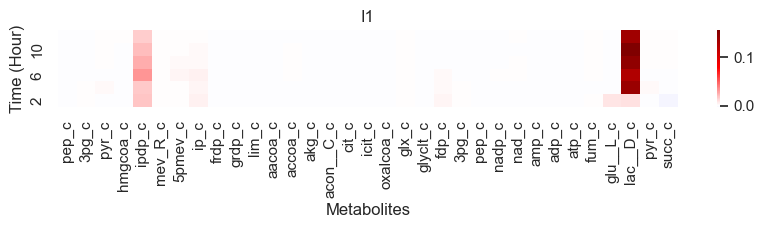

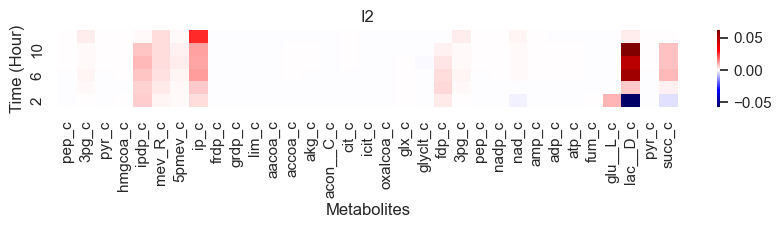

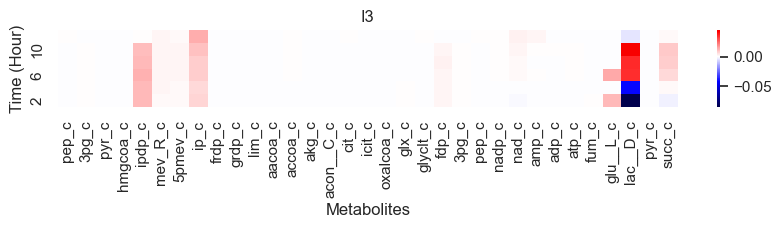

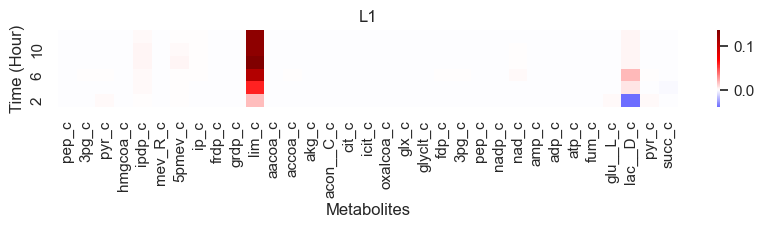

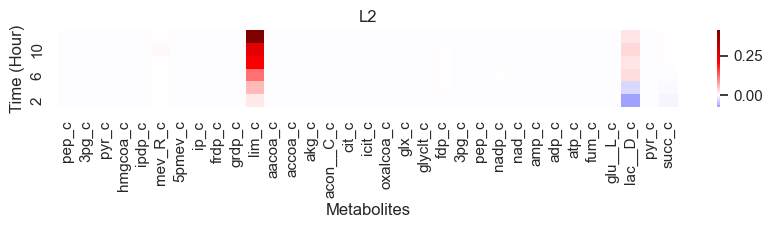

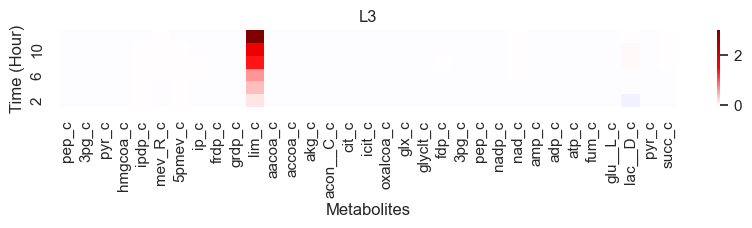

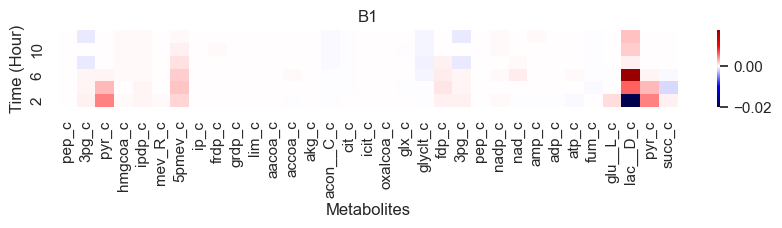

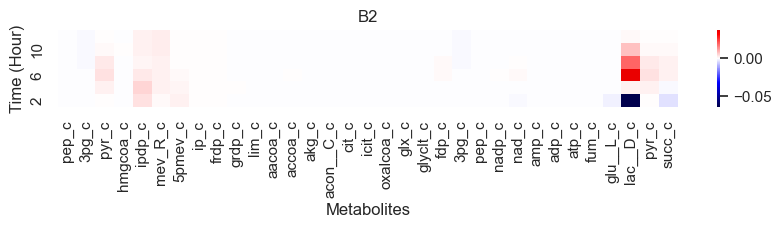

In [11]:
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,1)})

strains = [I1, I2, I3, L1, L2, L3, B1, B2]
strain_names = ['I1','I2','I3','L1','L2','L3','B1','B2']
for i in range(0,len(strains)):
    plt.figure()
    sns.heatmap(strains[i],cmap="seismic", center=0).set_title(strain_names[i])
    plt.gca().invert_yaxis() # Invert the y-axis to allow better interpretations from lowest number to highest number of hours
    plt.xlabel('Metabolites')
    plt.ylabel('Time (Hour)')

## Exercise

**Try on your own**

1. Find the metabolites and their time points that are varying the most between low production strains (I1, L1, B1) and high production strains (I3, L3, L2)

2. How do these metabolite concentrations change over time?

_____________________

## 3.0 Transform and Analyze the Protein data

In the following cell we will perform the following operations: 
    
> reset the index of the dataframe

Example: I1_prot_data_cobra.reset_index().drop('index', axis=1)
    
> subtract WT data from each engineered strain's data

Example: I1p.subtract(WT)

In [12]:
heterologous_proteins = ['ACACT1r','BISS','HMGR','HMGS','IPDDI','GRTT','LIMS','ERG1','NudB','MVD1','ERG8']

In [13]:
WT = DH1_prot_data_cobra.reset_index().drop('index',axis =1).drop(columns = heterologous_proteins)

I1p = I1_prot_data_cobra.reset_index().drop('index', axis=1).drop(columns = heterologous_proteins)
I1p = I1p.subtract(WT)

I2p = I2_prot_data_cobra.reset_index().drop('index', axis=1).drop(columns = heterologous_proteins)
I2p = I2p.subtract(WT)

I3p = I3_prot_data_cobra.reset_index().drop('index', axis=1).drop(columns = heterologous_proteins)
I3p = I3p.subtract(WT)

L1p = L1_prot_data_cobra.reset_index().drop('index', axis=1).drop(columns = heterologous_proteins)
L1p = L1p.subtract(WT)

L2p = L2_prot_data_cobra.reset_index().drop('index', axis=1).drop(columns = heterologous_proteins)
L2p = L2p.subtract(WT)

L3p = L3_prot_data_cobra.reset_index().drop('index', axis=1).drop(columns = heterologous_proteins)
L3p = L3p.subtract(WT)

B1p = B1_prot_data_cobra.reset_index().drop('index', axis=1).drop(columns = heterologous_proteins)
B1p = B1p.subtract(WT)

B2p = B2_prot_data_cobra.reset_index().drop('index', axis=1).drop(columns = heterologous_proteins)
B2p = B2p.subtract(WT)


We can now visualize changes between wild-type and engineered line using a heatmap plot. 

In the below cell, we use a for loop to iterate over all of the strains and make individual plots for each of them. 

> Example: for i in range(0,len(strains)):
> This command loops over the number of items in the list, strains

It then plots the data for each cell line using the command: 
> sns.heatmap(strains[i]).set_title(strain_names[i])

The heatmap shows which metabolites are significantly changing from wild-type for each engineered strain. 

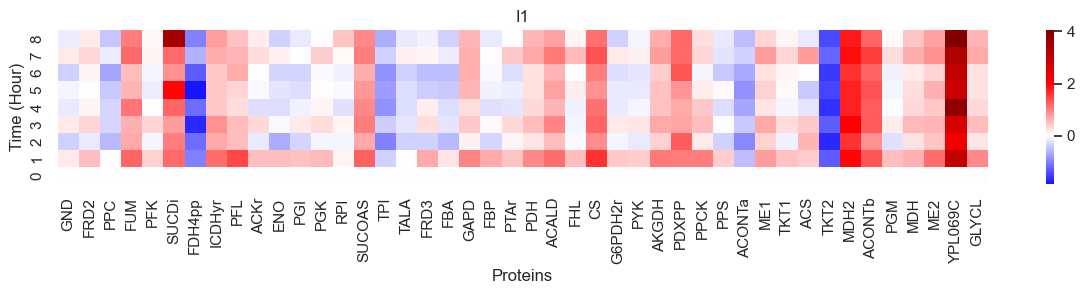

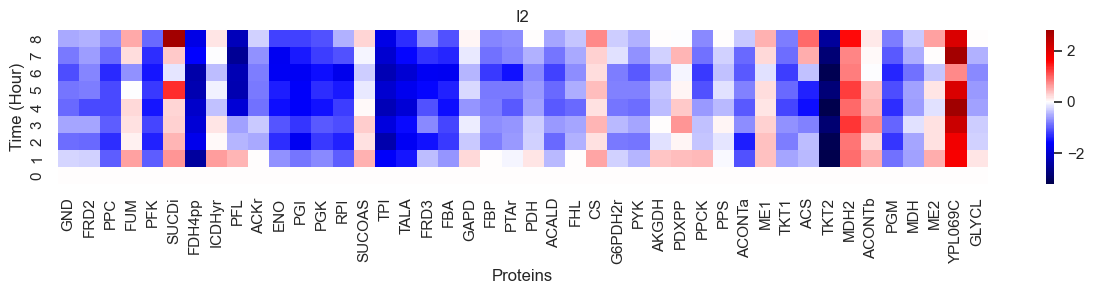

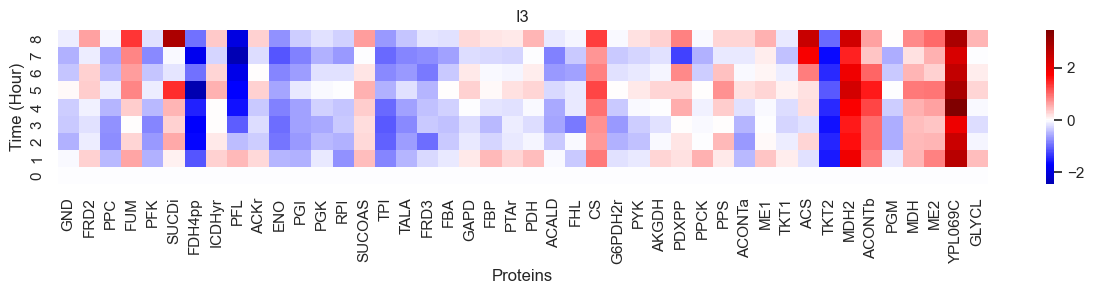

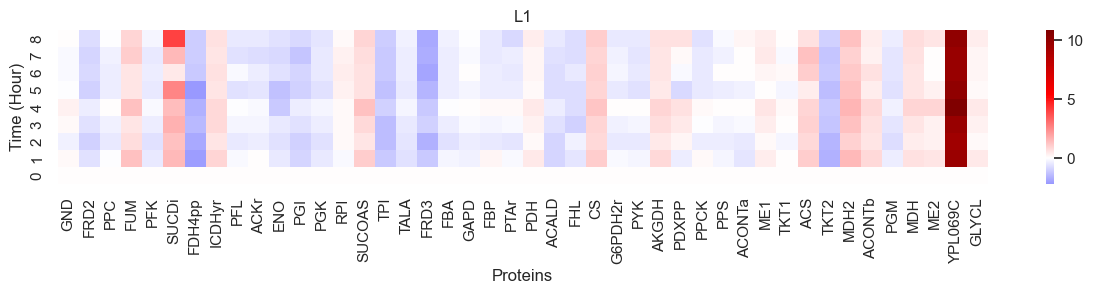

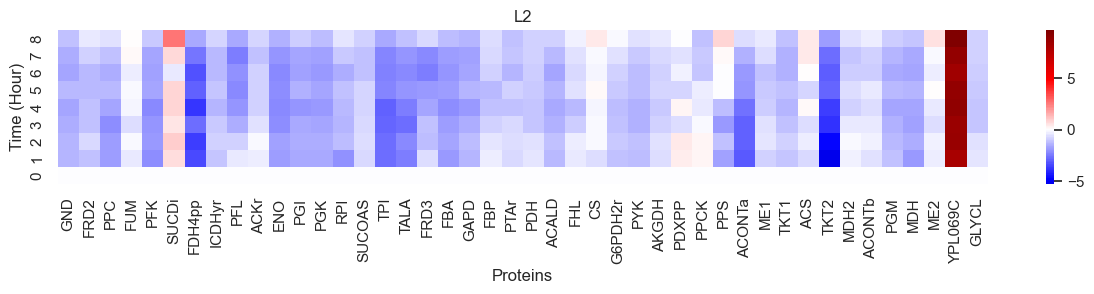

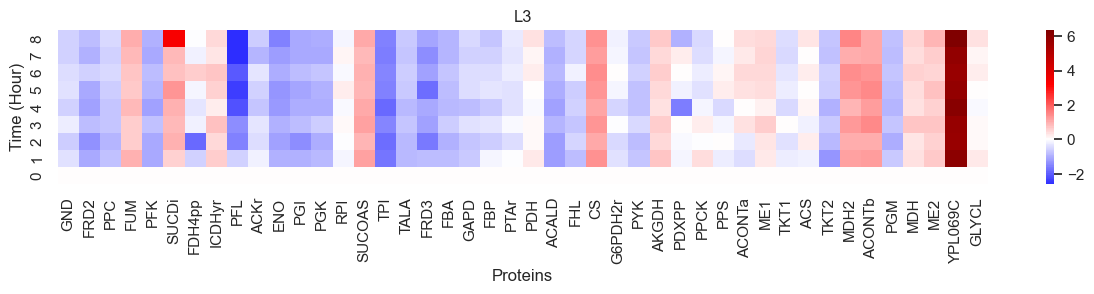

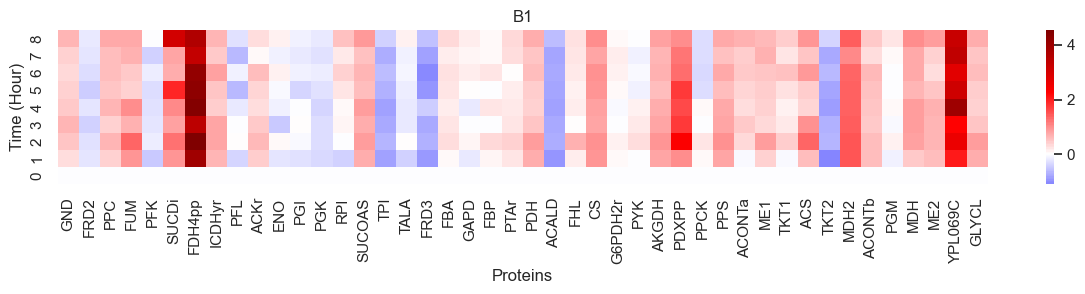

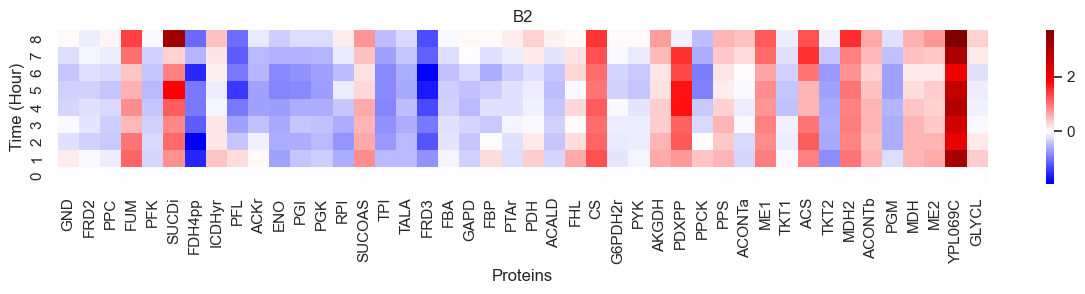

In [14]:
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(15,2)})

strains = [I1p, I2p, I3p, L1p, L2p, L3p, B1p, B2p]
strain_names = ['I1','I2','I3','L1','L2','L3','B1','B2'] #change titles (expression differences between WT and)
for i in range(0,len(strains)):
    plt.figure()#change y axis to actual time points (also for met)
    sns.heatmap(strains[i],cmap="seismic", center=0).set_title(strain_names[i])
    plt.gca().invert_yaxis() # Invert the y-axis to allow better interpretations from lowest number to highest number of hours
    plt.xlabel('Proteins')
    plt.ylabel('Time (Hour)')

## Exercise

**Try on your own**

1. Find the proteins and their time points that are varying the most between low production strains (I1, L1, B1) and high production strains (I3, L3, L2)

2. How do these protein levels change over time?

An example analysis for you to follow: 

A pythonic way to find the highest protein levels in B2 at timepoint #4 is shown below:

Let's breakdown the components of this simple script: 

> B2p is the name of the dataframe with B2 protein abundance

> .loc[4,i] is a command that allows you to locate the 4rth row and ith column

> B2p.loc[4,i] > 9 is telling the code to find any instances where the value in the 4rth row and any column is greater than 9

> [i for i in B2p.columns ....] is a way we can loop over the columns in the dataframe and print out all the values that meet our criteria

In [15]:
[i for i in B2p.columns if B2p.loc[4,i]>2]

['YPL069C']

There is one protein in the B2 strain, ERG8, that, at time point #4 (6 hrs), has the largest difference compared to wildtype E coli

If we want to figure out the protein name, we can use the "look up table" dataframe as shown below:

In [16]:
protein_IDs[protein_IDs.BiGG_id=='YPL069C']

,BiGG_id,GPR,reaction_name
name,,,
GPPS,YPL069C,NaN,YPL069C


Follow this "recipe" to find the proteins that show the largest differences in protein levels across the other high production and low production strains

What trends do you see?

## Exercise

**Try on your own**

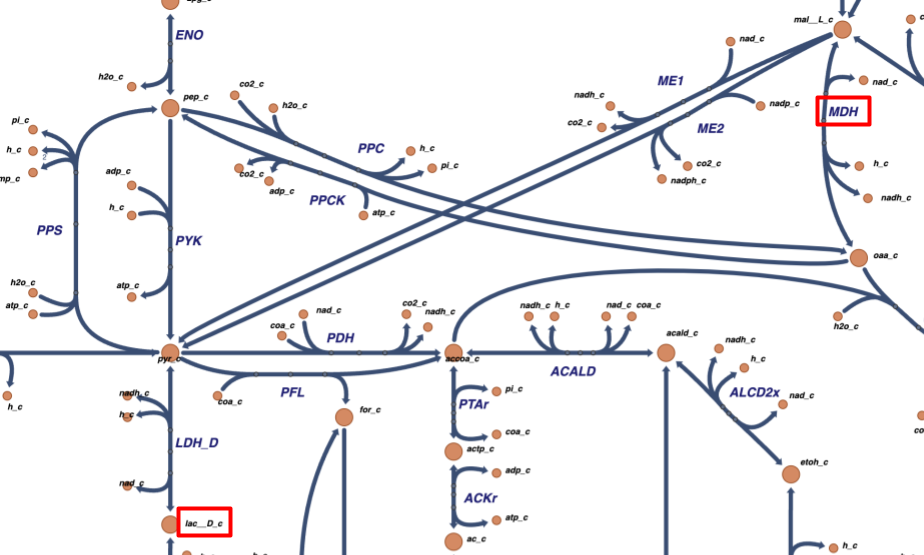

Load the e_coli_core metabolism in Escher (https://escher.github.io/#/) or refer to the screenshot above

1. Locate the MDH gene and the lac__D metabolite in the Escher pathway. What is the shortest pathway connecting the two? Look at the heatmap results in I3 for both the metabolites and the proteins (note: MDH2 in the heatmap is the same as MDH in the Escher pathway). Is there a connection between the Escher pathway and the heatmap results? 

_____________________________

## 4.0 Transform and Analyze the RNA data

The RNA data has been transformed and cleaned up, and the files are provided in the cell below:

These two files represent: 
> RNA sequencing of strain I3 and wild-type E coli at 1 hr

> RNA sequencing of strain I3 and wild-type E coli at 12 hrs
    

In [43]:
RNA_1_diff = pd.read_csv('data/RNA_1_diff.csv', index_col=0)
RNA_12_diff= pd.read_csv('data/RNA_12_diff.csv',  index_col=0)

Let's look inside these files to see what information is there: 

As an example, lets look at gene 'b3241'

In [44]:
print("This command gives the value of the RNA transcript level difference at 1 hr:",RNA_1_diff.loc[0,'b3241'])

print("This command gets the mean of all protein levels at 1 hr:",RNA_1_diff.iloc[0,:].mean())

This command gives the value of the RNA transcript level difference at 1 hr: 6.07127
This command gets the mean of all protein levels at 1 hr: 14.416018386784762


We can build a simple script to extract the genes that have the highest RNA at 1 hrs and 12 hrs. 

See the cell below:

In [45]:
# Code to extract genes with high mRNA at 1 hr
high_rna_1 = []
for i in RNA_1_diff.columns:
    if type(RNA_1_diff.loc[0,i]) == np.float64: # checks if the value in the dataframe is a number
        
        # only select genes that have higher values than the mean of all protein levels + 1 standard deviation
        if RNA_1_diff.loc[0,i] > RNA_1_diff.iloc[0,:].mean() + 1*RNA_1_diff.iloc[0,:].std():
            high_rna_1.append(i) # append gene to the list if it meets the criteria
            
# prints the total number of genes that meet the threshold
print(len(high_rna_1))

# Code to extract genes with high mRNA at 12 hr

high_rna_12 = []
for i in RNA_12_diff.columns:
    if type(RNA_12_diff.loc[0,i]) == np.float64:  # checks if the value in the dataframe is a number
        
        # only select genes that have higher values than the mean of all protein levels + 1 standard deviation

        if RNA_12_diff.loc[0,i] > RNA_12_diff.iloc[0,:].mean() + 1*RNA_12_diff.iloc[0,:].std():
            high_rna_12.append(i) # append gene to the list if it meets the criteria
            
# prints the total number of genes that meet the threshold
print(len(high_rna_12))


26
8


If you want to see which genes meet the criteria, you can simple look at the lists, as shown below:

In [46]:
high_rna_12

['b0631', 'b0812', 'b1562', 'b3687', 'b1685', 'b4493', 'b1597', 'b0953']

We can plot the subset of genes with the highest differences in RNA levels compared to wild-type

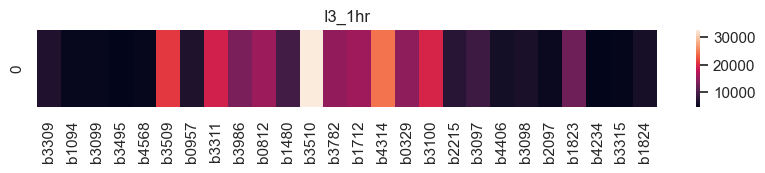

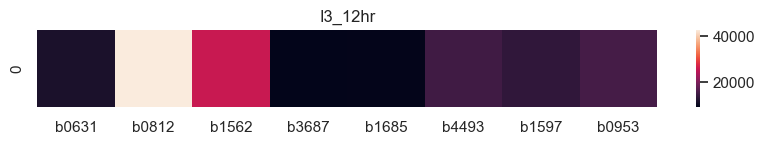

In [48]:
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,1)})

timepts = [RNA_1_diff[high_rna_1], RNA_12_diff[high_rna_12]]
names = ['I3_1hr','I3_12hr']
for i in range(0,len(timepts)):
    plt.figure()
    sns.heatmap(timepts[i]).set_title(names[i])

We can look to see which genes (and their expression values) meet the criteria by looking at the slice of the dataframe:

In [20]:
RNA_1_diff[high_rna_1]

,b3309,b1094,b3099,b3495,b4568,b3509,b0957,b3311,b3986,b0812,b1480,b3510,b3782,b1712,b4314,b0329,b3100,b2215,b3097,b4406,b3098,b2097,b1823,b4234,b3315,b1824
0,7035.45,5100.7,5118.348,4706.295,5065.666,20938.084,6852.295,19276.15,13288.75,15502.98,9593.66,32631.355,14858.05,15735.97,24428.25,14631.42,19563.645,7664.655,9020.49,6140.85,6599.905,5473.38,12612.06,4633.039,4854.35,6372.79


In [21]:
RNA_12_diff[high_rna_12]

,b0631,b0812,b1562,b3687,b1685,b4493,b1597,b0953
0,11606.273,42858.4,25810.2,9166.977,9388.45,14902.155,13424.341,15297.465


## Exercise

**Try on your own**

1. google the genes with the highest differences in both time points. What are their biological roles? What does this say about these engineered strains?
2. Modify the threshold so that we find and visualize genes that are higher than the mean + 0.5*standard deviation. How many genes fit this criteria at each time point?
3. Modify the threshold so that we find and visualize genes that are lower than the mean - 0.5*standard deviation. Are there any genes whose biological functions stand out as relevant to the engineering?
4. When looking at Question 3 from above, plot the subset of genes with the highest differences in RNA levels compared to wild-type.
